<a href="https://colab.research.google.com/github/IlaydaUtkuel/IlaydaUtkuel.github.io/blob/main/00_sanity_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 00 – Sanity Check (RGB → Segmentation)

Bu notebook ortamın doğru kurulduğunu ve tek bir U-Net modelinin **hatasız forward** çalıştığını doğrular.
- Kurulum: paketler
- Model: U-Net (resnet34)
- Çıktı: 1×H×W maske ve örnek görselleştirme


In [1]:
# --- [0] Kurulum + Import --- #
!pip -q install segmentation-models-pytorch timm albumentations opencv-python

import os
import torch, numpy as np, cv2, matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("✅ Ortam hazır | PyTorch:", torch.__version__, "| Cihaz:", device)

# Projede çıktıları standart bir yere kaydedelim:
PROJ_OUT = "outputs/figs"
os.makedirs(PROJ_OUT, exist_ok=True)
print("Çıktı klasörü:", os.path.abspath(PROJ_OUT))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.1 MB/s eta 0:00:00
✅ Ortam hazır | PyTorch: 2.8.0+cu126 | Cihaz: cuda
Çıktı klasörü: /content/outputs/figs


In [10]:
# --- [GIT-SETUP • ONE-CELL] LRZ/gitlab.com uyumlu --- #
# Bu hücre şunları yapar:
# 1) Git kimliğini ayarlar
# 2) Token'ı güvenli alır (getpass) ve /content'e repo'yu KLONLAR (yoksa)
# 3) origin'i tokensız URL'ye çevirir (token .git/config'te kalmasın)
# 4) Default branch'i tespit eder ve pull yapar
# 5) PROJ_OUT (outputs/figs) klasörünü repo içinde GARANTİ eder
# 6) git_auto_push(commit_message, paths, branch) fonksiyonunu tanımlar

import os, shutil, subprocess
from getpass import getpass

# === AYARLAR ===
HOST       = os.environ.get("GIT_HOST", "gitlab.lrz.de")   # gitlab.com kullanıyorsan bunu "gitlab.com" yap
REPO       = os.environ.get("GIT_REPO", "avist/avist-vene-detection-ml")  # grup/yol/repoadı
REPO_DIR   = "/content/avist-vene-detection-ml"
USER_EMAIL = "senin_mailin@tum.de"
USER_NAME  = "Ilayda Utkuel"

# 1) Git kimliği
os.system(f'git config --global user.email "{USER_EMAIL}"')
os.system(f'git config --global user.name "{USER_NAME}"')

# 2) Token (env'de yoksa getpass ile iste)
if not os.environ.get("GITLAB_TOKEN"):
    os.environ["GITLAB_TOKEN"] = getpass("GitLab Personal Access Token (write+read): ")

def is_git_repo(path):
    try:
        return subprocess.run(["git","-C", path, "rev-parse","--is-inside-work-tree"],
                              capture_output=True, text=True).returncode == 0
    except Exception:
        return False

# 3) Klon (yoksa); varsa atla
if not (os.path.isdir(REPO_DIR) and is_git_repo(REPO_DIR)):
    if os.path.isdir(REPO_DIR):
        shutil.rmtree(REPO_DIR)
    auth_url = f"https://oauth2:{os.environ['GITLAB_TOKEN']}@{HOST}/{REPO}.git"
    os.system(f"git clone {auth_url} {REPO_DIR}")
else:
    print("✓ Repo zaten klonlanmış.")

os.chdir(REPO_DIR)
# Token'ı .git/config'te saklamamak için origin'i tokensız URL'ye ayarla
os.system(f"git remote set-url origin https://{HOST}/{REPO}.git")

# Helper: default branch tespiti (main/master)
def _detect_branch():
    for b in ("main","master"):
        r = subprocess.run(["git","rev-parse","--verify", b], capture_output=True)
        if r.returncode == 0:
            return b
    r = subprocess.run(["git","rev-parse","--abbrev-ref","HEAD"], capture_output=True, text=True)
    return (r.stdout or "main").strip()

BRANCH = _detect_branch()
os.system(f"git pull origin {BRANCH}")

# 4) PROJ_OUT'u repo içine sabitle ve garanti et
PROJ_OUT = os.path.join(REPO_DIR, "outputs/figs")
os.makedirs(PROJ_OUT, exist_ok=True)
print("Repo:", REPO_DIR)
print("Branch:", BRANCH)
print("PROJ_OUT:", PROJ_OUT)

# 5) Auto-push fonksiyonu
def git_auto_push(commit_message="Auto commit from Colab", paths=None, branch=None):
    """
    paths: ['outputs/figs'] gibi liste verirsen sadece o yollar eklenir; None -> tüm repo eklenir.
    branch: None ise otomatik tespit edilen BRANCH kullanılır.
    """
    import os
    os.chdir(REPO_DIR)
    b = branch or BRANCH
    os.system(f"git pull origin {b}")
    if paths:
        for p in paths:
            os.system(f"git add {p}")
    else:
        os.system("git add .")
    os.system(f'git commit -m "{commit_message}" || echo "No changes to commit"')
    push_url = f"https://oauth2:{os.environ['GITLAB_TOKEN']}@{HOST}/{REPO}.git"
    os.system(f"git push {push_url} {b}")
    print("✅ Push ok.")


✓ Repo zaten klonlanmış.
Repo: /content/avist-vene-detection-ml
Branch: main
PROJ_OUT: /content/avist-vene-detection-ml/outputs/figs


In [4]:
# --- Model ve Dummy Girdi ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unet(encoder_name='resnet34', in_channels=3, classes=1).to(device).eval()
x = torch.randn(1, 3, 256, 256, device=device)
with torch.no_grad():
    y = model(x)
print('Input shape:', tuple(x.shape))
print('Output shape:', tuple(y.shape))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Input shape: (1, 3, 256, 256)
Output shape: (1, 1, 256, 256)


In [6]:
# Kaydetme hedefini repo içine sabitle ve klasörü garanti et
if 'REPO_DIR' in globals():
    PROJ_OUT = os.path.join(REPO_DIR, "outputs/figs")
else:
    PROJ_OUT = "outputs/figs"

import os
os.makedirs(PROJ_OUT, exist_ok=True)

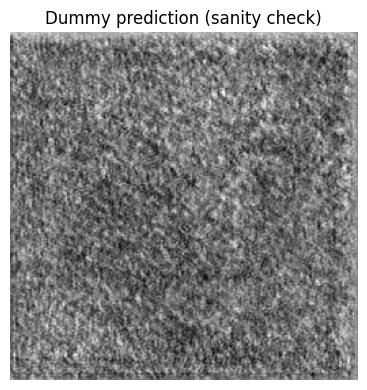

Saved: outputs/figs/dummy_output_20251102-193944.png


In [7]:
# --- Görselleştirme (sanity check) ---
import time
ts = time.strftime("%Y%m%d-%H%M%S")

# 1-kanallı olasılık haritası (0..1)
prob = torch.sigmoid(y[0, 0]).detach().float().cpu().numpy()

plt.figure(figsize=(4,4))
plt.imshow(prob, cmap='gray')
plt.title('Dummy prediction (sanity check)')
plt.axis('off')
plt.tight_layout()

# çıktıyı dosyaya kaydet
fname = f"dummy_output_{ts}.png"
fpath = os.path.join(PROJ_OUT, fname)
plt.savefig(fpath, dpi=150)
plt.show()
print("Saved:", fpath)


In [8]:
# --- Hızlı istatistikler ---
import numpy as np

print("Mask prob stats:",
      "min=", float(np.min(prob)),
      "max=", float(np.max(prob)),
      "mean=", float(np.mean(prob)),
      "std=", float(np.std(prob)))

# (İsteğe bağlı) ikili maske görmek istersen:
th = 0.5
binary = (prob >= th).astype(np.uint8)
print("Binary ratio (>=0.5):", float(binary.mean()))


Mask prob stats: min= 0.25594842433929443 max= 0.7427781224250793 mean= 0.47439688444137573 std= 0.06493321061134338
Binary ratio (>=0.5): 0.3367462158203125


In [11]:
# --- GitLab'a push (opsiyonel) ---
# Güvenli kontrol: bu oturumda GIT-SETUP çalışmış mı, dosya oluşmuş mu?
assert 'git_auto_push' in globals(), "Önce GIT-SETUP hücresini çalıştır (git_auto_push tanımlı değil)."
assert 'fpath' in globals(), "Önce görselleştirme hücresini çalıştır (fpath oluşturulmalı)."

import os
# Sadece figürleri eklemek istersen:
git_auto_push(f"Add {os.path.basename(fpath)} (sanity check)", paths=['outputs/figs'])

# # İstersen ileride metrik/log da eklersin:
# git_auto_push("Add figs + metrics", paths=['outputs/figs','outputs/metrics'])


✅ Push ok.


## Sonraki adım
- 2–3 gerçek RGB görüntü ve bunlara karşılık gelen **dummy** maskeler ile çalıştır.
- Ardından gerçek veri seti ile eğitim döngüsüne geçilecektir.


In [ ]:
!apt-get update -qq
!apt-get install -y git-lfs >/dev/null
!git lfs install

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.


In [12]:
import os, subprocess
os.chdir(REPO_DIR)
res = subprocess.run(["git","lfs","ls-files"], capture_output=True, text=True)
print(res.stdout if res.stdout else "No LFS-tracked files.")

281f1f904f * outputs/figs/dummy_output_20251102-193944.png



In [ ]:
# Nerede olduğuna bak
%pwd
# İçeriği listele (avist-vene-detection-ml var mı?)
!ls -la /content

# Depo klasörüne geç
%cd /content/avist-vene-detection-ml

# Gerçekten içindeyiz mi, görelim
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Oct 27 21:35 .
drwxr-xr-x 1 root root 4096 Oct 27 21:31 ..
drwxr-xr-x 4 root root 4096 Oct 24 13:37 .config
drwxr-xr-x 1 root root 4096 Oct 24 13:37 sample_data
[Errno 2] No such file or directory: '/content/avist-vene-detection-ml'
/content
total 16
drwxr-xr-x 1 root root 4096 Oct 27 21:35 .
drwxr-xr-x 1 root root 4096 Oct 27 21:31 ..
drwxr-xr-x 4 root root 4096 Oct 24 13:37 .config
drwxr-xr-x 1 root root 4096 Oct 24 13:37 sample_data


In [ ]:
from getpass import getpass
import os

tok = getpass("GitLab Personal Access Token (görünmeyecek): ")
os.environ["GITLAB_TOKEN"] = tok
print("GITLAB_TOKEN uzunluğu:", len(tok))


GitLab Personal Access Token (görünmeyecek): ··········
GITLAB_TOKEN uzunluğu: 55


In [ ]:
# Klasörü temizle (varsa) ve klonla
import os, shutil, subprocess, sys

repo_url = "https://00000000014A4E13:%s@gitlab.lrz.de/avist/avist-vene-detection-ml.git" % os.environ.get("GITLAB_TOKEN","")
target = "/content/avist-vene-detection-ml"

if os.path.isdir(target):
    shutil.rmtree(target)

# Git LFS kur & aktif et
!apt-get update -qq
!apt-get install -y git-lfs >/dev/null
!git lfs install

# Klonla
!git clone "{repo_url}" "{target}"

# Repo'ya gir
%cd /content/avist-vene-detection-ml

# LFS içerikleri çek
!git lfs pull
!git lfs checkout

# Hızlı kontrol
!git rev-parse --is-inside-work-tree
!ls -la
!find data -maxdepth 2 -type d -name "NTU_*" || true


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.
Cloning into '/content/avist-vene-detection-ml'...
remote: Enumerating objects: 3532, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3532 (delta 7), reused 36 (delta 6), pack-reused 3492 (from 1)
Receiving objects: 100% (3532/3532), 499.44 KiB | 796.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.
Filtering content: 100% (3477/3477), 111.49 MiB | 728.00 KiB/s, done.
/content/avist-vene-detection-ml
Checking out LFS objects: 100% (3503/3503), 117 MB | 0 B/s, done.
true
total 48
drwxr-xr-x 9 root root 4096 Oct 28 09:51 .
drwxr-xr-x 1 root root 4096 Oct 28 09:51 ..
drwxr-xr-x 3 root root 4096 Oct 28 09:51 data
drwxr-xr-x 2 root root 4096 Oct 28 09:51 docs
drwxr-xr-x 2 root root 4096 Oct 28 09:51 experiments
drwxr

In [ ]:
# Repo klasörüne gir
%cd /content/avist-vene-detection-ml

# LFS içeriğini çek ve pointer'ları dosyaya dönüştür
!git lfs pull
!git lfs checkout

# LFS'e kayıtlı kaç dosya var, hızlı kontrol
!git lfs ls-files | wc -l


/content/avist-vene-detection-ml
Checking out LFS objects: 100% (3503/3503), 117 MB | 0 B/s, done.
3477


In [ ]:
# Beklenen veri klasörü var mı?
!test -d data/NTU_Inner_Forearm_v2 && echo "✅ NTU_Inner_Forearm_v2 var" || echo "❌ NTU_Inner_Forearm_v2 YOK"

# İçeride neler var, ilk seviyeyi göster
!find data -maxdepth 2 -type d -name "NTU_*" -print

# Boyuta bak (varsa)
!du -sh data/NTU_Inner_Forearm_v2 2>/dev/null || echo "du: klasör yok"


✅ NTU_Inner_Forearm_v2 var
data/NTU_Inner_Forearm_v2
119M	data/NTU_Inner_Forearm_v2


In [ ]:
import os, glob, pathlib
ir_dir = pathlib.Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/IR")
rgb_dir = pathlib.Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/RGB")

print("IR klasörü var mı?", ir_dir.is_dir())
print("RGB klasörü var mı?", rgb_dir.is_dir())

patterns = ["*.png","*.jpg","*.jpeg","*.tif","*.tiff","*.bmp"]
ir_files = []
for p in patterns:
    ir_files += glob.glob(str(ir_dir / p))

print("IR görsel sayısı:", len(ir_files))
print("Örnek ilk 5:", ir_files[:5])


IR klasörü var mı? True
RGB klasörü var mı? False
IR görsel sayısı: 0
Örnek ilk 5: []


In [ ]:
%%bash
# Klasör ağaç görünümü (ilk birkaç seviye)
ls -la /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2 || true
find /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2 -maxdepth 3 -type d -print

# IR içinde neler var? (ilk 200 satır liste)
ls -la /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/IR | head -n 200 || true

# RGB adlı klasör var mı? (isim varyasyonlarını ara)
find /content/avist-vene-detection-ml/data -maxdepth 3 -type d \( -iname "*rgb*" -o -iname "*vis*" \) -print


total 24
drwxr-xr-x 5 root root 4096 Oct 28 09:51 .
drwxr-xr-x 3 root root 4096 Oct 28 09:51 ..
drwxr-xr-x 4 root root 4096 Oct 28 09:51 internet
drwxr-xr-x 4 root root 4096 Oct 28 09:51 IR
-rw-r--r-- 1 root root  212 Oct 28 09:51 README.txt
drwxr-xr-x 4 root root 4096 Oct 28 09:51 standard
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/standard
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/standard/Imgseg_01
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/standard/Imgseg_02
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/IR
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/IR/Imgseg_01
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/IR/Imgseg_02
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/internet
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/internet/Imgseg_01
/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/internet/Imgse

In [ ]:
from pathlib import Path
root = Path("/content/avist-vene-detection-ml")
ir_base = root/"data/NTU_Inner_Forearm_v2/IR"

# Varsayılan olarak en sık uzantıları tarayalım
EXTS = [".png",".jpg",".jpeg",".tif",".tiff",".bmp"]

def list_images(folder):
    return [p for p in folder.iterdir() if p.suffix.lower() in EXTS]

for split in ["Imgseg_01","Imgseg_02"]:
    d = ir_base/split
    files = list_images(d) if d.is_dir() else []
    print(f"{split}: {len(files)} dosya")
    print("Örnek:", [p.name for p in files[:5]])


Imgseg_01: 656 dosya
Örnek: ['seg_AL0277_00_01_01.png', 'seg_AR0042_00_01_01.png', 'seg_AR0185_00_01_01.png', 'seg_AL0155_00_01_01.png', 'seg_AR0092_00_01_01.png']
Imgseg_02: 656 dosya
Örnek: ['seg_AL0092_00_02_01.png', 'seg_AL0028_00_02_01.png', 'seg_AL0060_00_02_01.png', 'seg_AL0142_00_02_01.png', 'seg_AR0308_00_02_01.png']


In [ ]:
from tqdm import tqdm

splits = ["Imgseg_01","Imgseg_02"]
processed, skipped = 0, 0

for split in splits:
    in_dir  = ir_base/split
    out_dir = out_base/split
    if not in_dir.is_dir():
        print(f"Atlandı (yok): {in_dir}")
        continue
    ensure_dir(out_dir)

    files = [p for p in in_dir.iterdir() if p.suffix.lower() in EXTS]
    for p in tqdm(files, desc=f"IR→mask: {split}"):
        img = read_gray(p)
        if img is None:
            skipped += 1
            continue
        # 1) Kontrast artır
        g = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        g = clahe(g, clip=2.0, tile=8)
        # 2) Damar belirginleştirme (Frangi-like)
        v = frangi_like(g, sigmas=(1,2,3), beta=0.5, c=20)
        # 3) Otsu eşik
        thr, binmask = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # 4) Morfoloji + küçük parça temizleme
        binmask = postprocess_binary(binmask, open_ks=3, close_ks=5, min_area=50)

        out_path = out_dir/(p.stem + "_mask.png")
        cv2.imwrite(str(out_path), binmask)
        processed += 1

print(f"Tamamlandı. Üretilen maske: {processed}, atlanan: {skipped}")
print("Maskeler:", out_base)


NameError: name 'out_base' is not defined

In [ ]:
# === IR → Maske üretimi: tek hücrelik, bağımsız sürüm ===
from pathlib import Path
import cv2
import numpy as np

# 1) Dizinler
root     = Path("/content/avist-vene-detection-ml")
ir_base  = root / "data/NTU_Inner_Forearm_v2/IR"
out_base = root / "data/NTU_Inner_Forearm_v2/masks_IR"
splits   = ["Imgseg_01", "Imgseg_02"]

out_base.mkdir(parents=True, exist_ok=True)

# 2) Basit ve sağlam bir IR->maske boru hattı (parametreleri gerektiğinde ayarlayabiliriz)
def ir_to_mask(ir_img):
    """
    Beklenen giriş: 8-bit tek kanal (grayscale) IR görüntü.
    Çıktı: 0/255 binary maske (uint8).
    """
    if ir_img is None:
        return None

    # a) Kontrast artırma (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(ir_img)

    # b) Gürültü bastırma
    g = cv2.GaussianBlur(g, (5,5), 0)

    # c) Black-hat (damar gibi koyu-ince yapıları öne çıkarır)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    bh = cv2.morphologyEx(g, cv2.MORPH_BLACKHAT, kernel)

    # d) Normalize edip ikili eşik
    bh = cv2.normalize(bh, None, 0, 255, cv2.NORM_MINMAX)
    _, mask = cv2.threshold(bh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # e) Morfolojik temizlik (küçük boşlukları doldur / gürültüyü kırp)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)

    return mask

# 3) Döngü: her split için tüm IR dosyalarını işle
total_in, total_out, total_empty = 0, 0, 0

for split in splits:
    in_dir  = ir_base / split
    out_dir = out_base / split
    if not in_dir.is_dir():
        print(f"Atlandı (yok): {in_dir}")
        continue
    out_dir.mkdir(parents=True, exist_ok=True)

    # yalnızca tipik görüntü uzantıları
    exts = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")
    files = [p for p in in_dir.iterdir() if p.suffix.lower() in exts]
    files.sort()
    print(f"[{split}] {len(files)} IR dosyası bulundu.")
    total_in += len(files)

    for p in files:
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        mask = ir_to_mask(img)
        if mask is None:
            continue

        # Çıktı adı: seg_XXX.png -> seg_XXX_mask.png
        out_name = p.stem + "_mask.png"
        out_path = out_dir / out_name
        cv2.imwrite(str(out_path), mask)
        total_out += 1
        if np.count_nonzero(mask) == 0:
            total_empty += 1

print("\n--- Özet ---")
print("Girdi IR sayısı:", total_in)
print("Üretilen maske sayısı:", total_out)
print("Boş maske (tamamı sıfır piksel):", total_empty)
print("Maskeler burada:", out_base)


[Imgseg_01] 656 IR dosyası bulundu.
[Imgseg_02] 656 IR dosyası bulundu.

--- Özet ---
Girdi IR sayısı: 1312
Üretilen maske sayısı: 1312
Boş maske (tamamı sıfır piksel): 0
Maskeler burada: /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/masks_IR


Toplam eşleşen çift: 1312


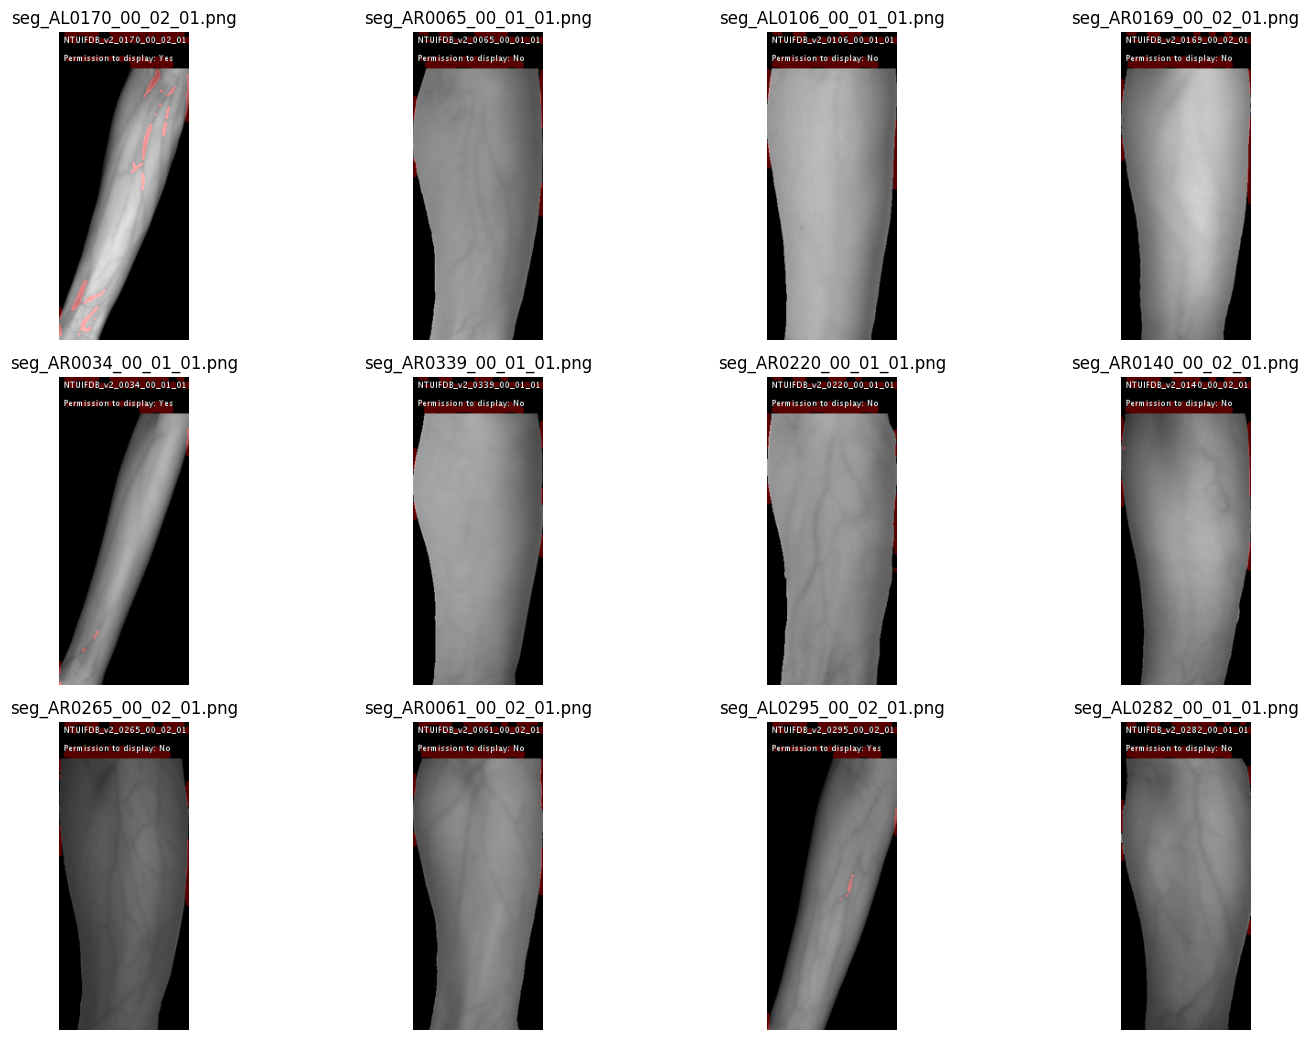

In [ ]:
import random, math
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt

root = Path("/content/avist-vene-detection-ml")
ir_base  = root / "data/NTU_Inner_Forearm_v2/IR"
msk_base = root / "data/NTU_Inner_Forearm_v2/masks_IR"

def collect_pairs(split):
    ir_dir  = ir_base/split
    msk_dir = msk_base/split
    exts = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")
    pairs = []
    for p in sorted(ir_dir.iterdir()):
        if p.suffix.lower() not in exts:
            continue
        m = msk_dir / (p.stem + "_mask.png")
        if m.is_file():
            pairs.append((p,m))
    return pairs

pairs = collect_pairs("Imgseg_01") + collect_pairs("Imgseg_02")
print("Toplam eşleşen çift:", len(pairs))

sample = random.sample(pairs, k=min(12, len(pairs)))

cols = 4
rows = math.ceil(len(sample)/cols)
plt.figure(figsize=(4*cols, 3.5*rows))

for i,(pi,pm) in enumerate(sample,1):
    ir = cv2.imread(str(pi), cv2.IMREAD_GRAYSCALE)
    mk = cv2.imread(str(pm), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(ir, cv2.COLOR_GRAY2RGB)
    # maskeyi renklendir (kırmızı kanal), alfa karışımı
    color = np.zeros_like(overlay)
    color[:,:,0] = mk  # R kanalı
    alpha = 0.35
    blended = cv2.addWeighted(overlay, 1.0, color, alpha, 0)
    plt.subplot(rows, cols, i); plt.imshow(blended, cmap='gray'); plt.axis('off')
    plt.title(pi.name)

plt.tight_layout(); plt.show()


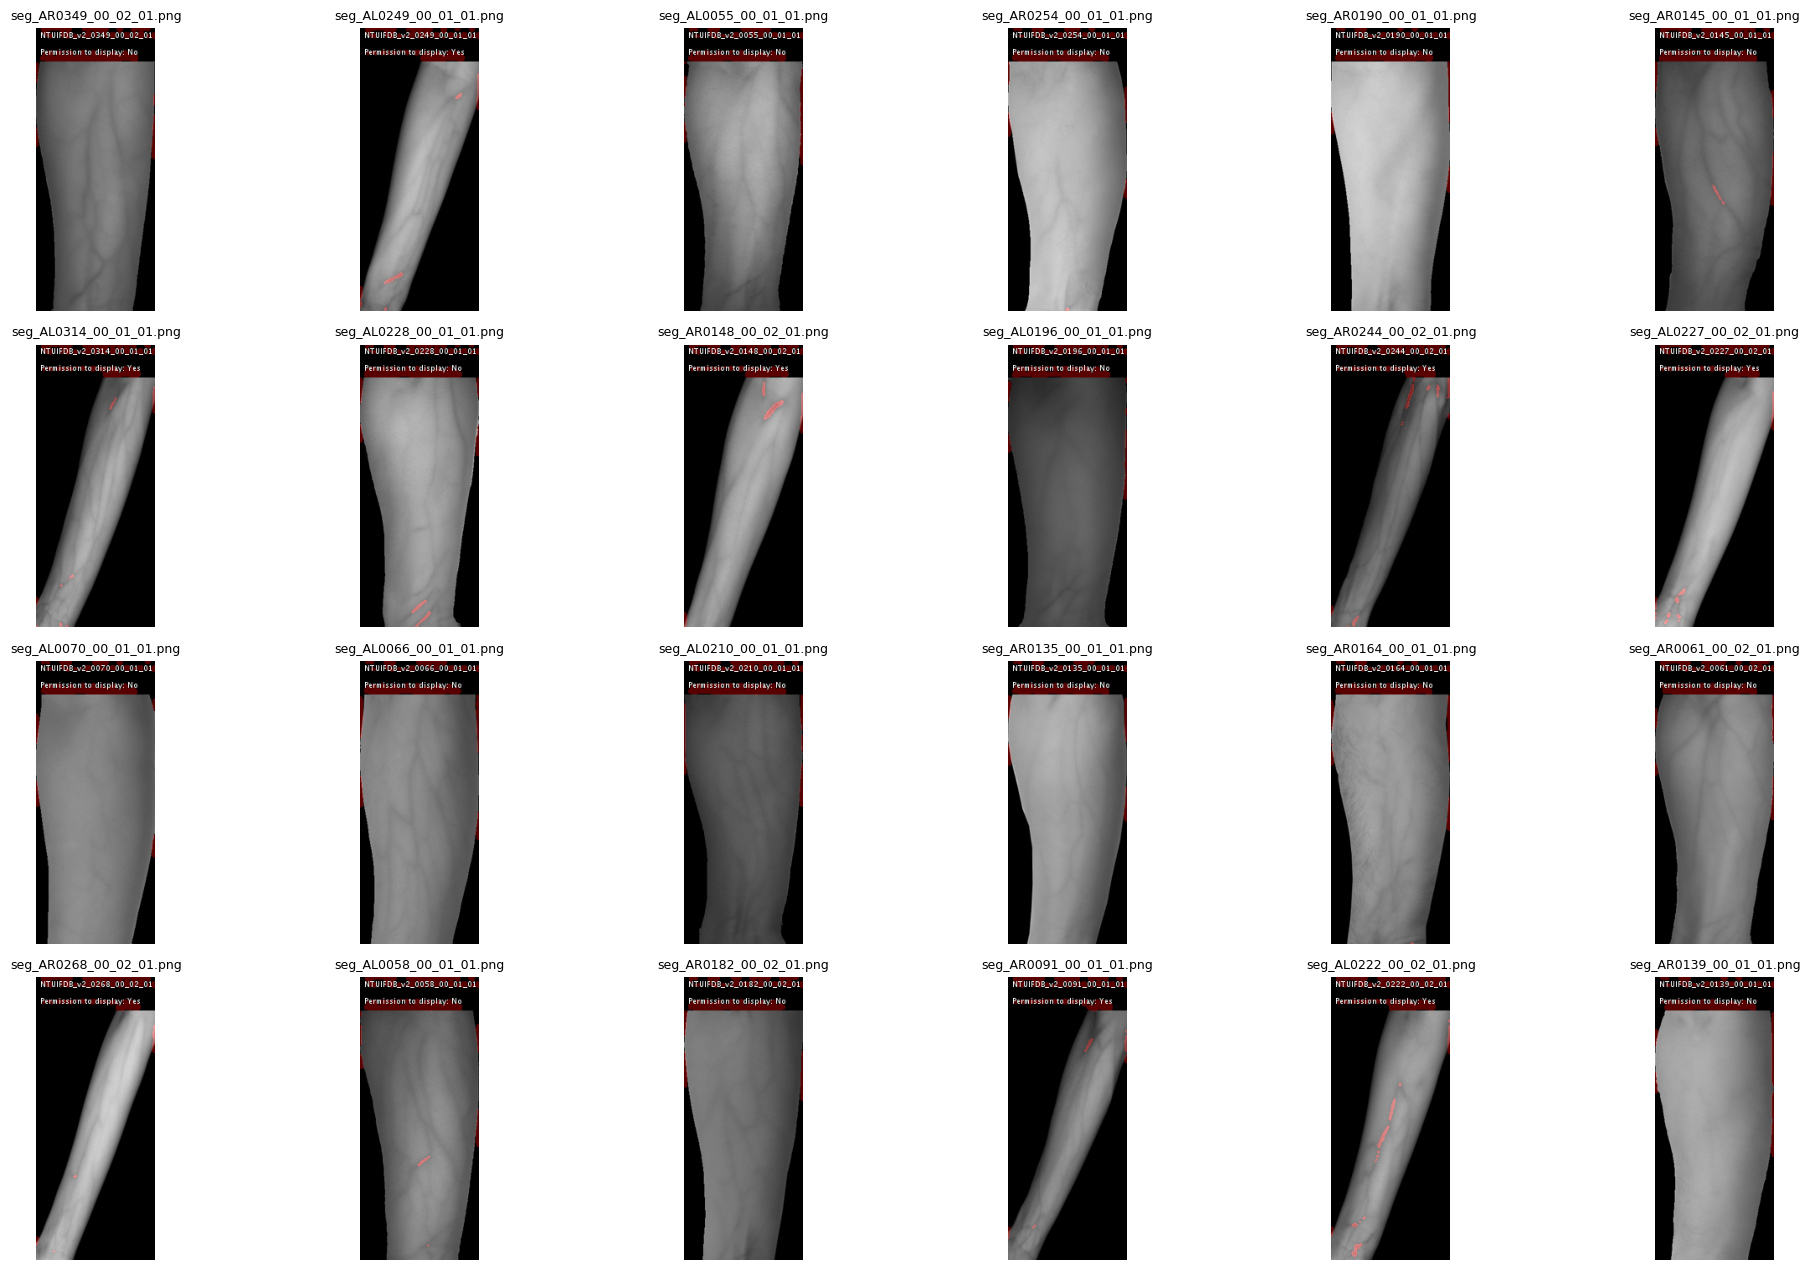

Kaydedildi: /content/ir_mask_grid.png


In [ ]:
import random, math
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt

random.seed(42)  # tekrarlanabilir olsun
root = Path("/content/avist-vene-detection-ml")
ir_base  = root / "data/NTU_Inner_Forearm_v2/IR"
msk_base = root / "data/NTU_Inner_Forearm_v2/masks_IR"

def collect_pairs(split):
    pairs=[]
    for p in sorted((ir_base/split).glob("*")):
        if p.suffix.lower() not in [".png",".jpg",".jpeg",".tif",".tiff",".bmp"]:
            continue
        m = msk_base/split/(p.stem + "_mask.png")
        if m.exists(): pairs.append((p,m))
    return pairs

pairs = collect_pairs("Imgseg_01") + collect_pairs("Imgseg_02")
k = min(24, len(pairs))
sample = random.sample(pairs, k=k)

cols=6; rows=math.ceil(k/cols)
plt.figure(figsize=(3.5*cols, 3.2*rows))
for i,(pi,pm) in enumerate(sample,1):
    ir = cv2.imread(str(pi), cv2.IMREAD_GRAYSCALE)
    mk = cv2.imread(str(pm), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(ir, cv2.COLOR_GRAY2RGB)
    color = np.zeros_like(overlay); color[:,:,0] = mk  # kırmızı kanal
    blended = cv2.addWeighted(overlay, 1.0, color, 0.35, 0)
    plt.subplot(rows, cols, i); plt.imshow(blended); plt.axis('off'); plt.title(pi.name, fontsize=9)
plt.tight_layout()
plt.savefig("/content/ir_mask_grid.png", dpi=200)
plt.show()

print("Kaydedildi: /content/ir_mask_grid.png")


Örnek: 1312 Min/Med/Mean/Max: 0.03475289607467289 0.04649345778814901 0.0480719842761287 0.09192432702725227


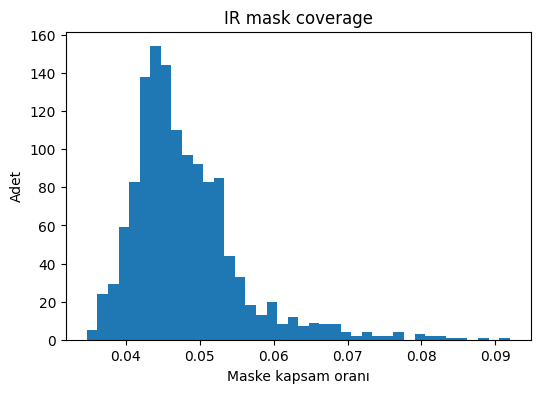

Çok düşükten örnekler: []
Çok yüksekten örnekler: []


In [ ]:
import numpy as np, cv2
from pathlib import Path
import matplotlib.pyplot as plt

msk_base = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/masks_IR")
ratios=[]
mask_paths=[]
for split in ["Imgseg_01","Imgseg_02"]:
    for p in sorted((msk_base/split).glob("*.png")):
        mk = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if mk is None: continue
        r = (mk>0).sum()/mk.size
        ratios.append(r); mask_paths.append(p)

ratios = np.array(ratios)
print("Örnek:", ratios.size, "Min/Med/Mean/Max:", ratios.min(), np.median(ratios), ratios.mean(), ratios.max())

plt.figure(figsize=(6,4)); plt.hist(ratios, bins=40)
plt.xlabel("Maske kapsam oranı"); plt.ylabel("Adet"); plt.title("IR mask coverage")
plt.show()

low_thr, high_thr = 0.002, 0.25
idx_low  = np.where(ratios<low_thr)[0][:10]
idx_high = np.where(ratios>high_thr)[0][:10]
print("Çok düşükten örnekler:", [mask_paths[i].name for i in idx_low])
print("Çok yüksekten örnekler:", [mask_paths[i].name for i in idx_high])


In [ ]:
import cv2, matplotlib.pyplot as plt
from pathlib import Path

def show_pair(mask_name):
    m = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/masks_IR")
    # split bilinmiyorsa iki klasörde ara
    cand = list((m/"Imgseg_01").glob(mask_name)) + list((m/"Imgseg_02").glob(mask_name))
    assert cand, "Maske bulunamadı"
    pm = cand[0]
    pi = Path(str(pm).replace("/masks_IR/","/IR/").replace("_mask.png",".png"))  # IR yolunu türet
    ir = cv2.imread(str(pi), cv2.IMREAD_GRAYSCALE)
    mk = cv2.imread(str(pm), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.cvtColor(ir, cv2.COLOR_GRAY2RGB)
    color = overlay*0; color[:,:,0]=mk
    out = cv2.addWeighted(overlay,1.0,color,0.35,0)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(ir, cmap='gray'); plt.title(pi.name); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(out); plt.title(pm.name); plt.axis('off')
    plt.tight_layout(); plt.show()

# Örnek kullanım:
# show_pair("seg_AL0277_00_01_01_mask.png")


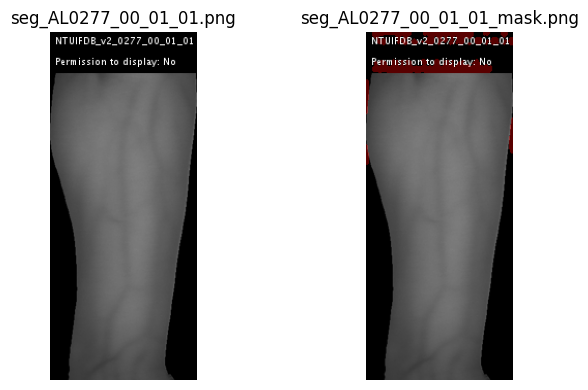

In [ ]:
def show_by_ir_name(ir_name):
    # ir_name örn: "seg_AL0277_00_01_01.png"
    show_pair(ir_name.replace(".png", "_mask.png"))

show_by_ir_name("seg_AL0277_00_01_01.png")


In [ ]:
from pathlib import Path
import cv2
import numpy as np

root = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
msk = root/"masks_IR/Imgseg_01/seg_AL0277_00_01_01_mask.png"  # Imgseg_02 ise bunu değiştir
print("Dosya var mı? ", msk.exists(), "\nYol:", msk)

# Maskeyi oku ve değerlerini incele
if msk.exists():
    m = cv2.imread(str(msk), cv2.IMREAD_UNCHANGED)  # tek kanal gelmeli
    print("Şekil:", None if m is None else m.shape)
    if m is not None:
        vals = np.unique(m)
        print("Eşsiz piksel değerleri (ilk 20):", vals[:20])
        print("Min/Max:", m.min(), m.max())


Dosya var mı?  True 
Yol: /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/masks_IR/Imgseg_01/seg_AL0277_00_01_01_mask.png
Şekil: (338, 142)
Eşsiz piksel değerleri (ilk 20): [  0 255]
Min/Max: 0 255


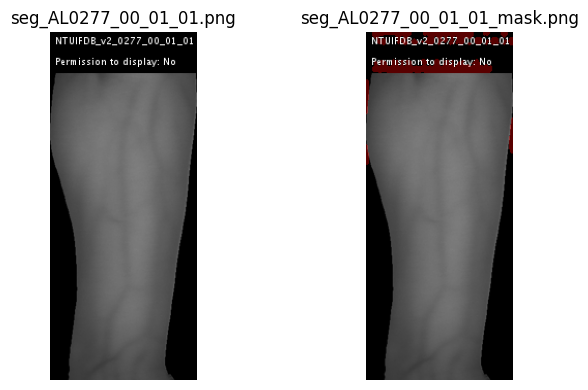

In [ ]:
show_by_ir_name("seg_AL0277_00_01_01.png")  # Imgseg_01 için


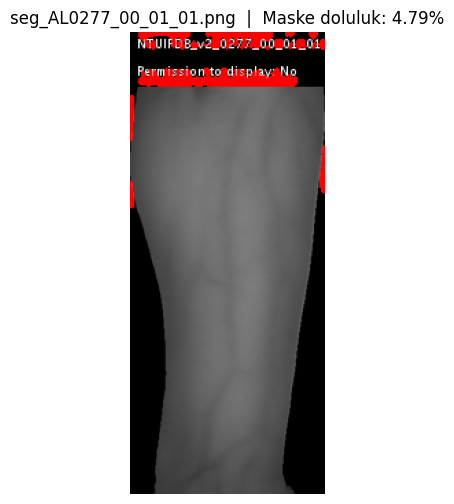

In [ ]:
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR_DIR    = ROOT/"IR/Imgseg_01"          # Imgseg_02 ise bunu değiştir
MASK_DIR  = ROOT/"masks_IR/Imgseg_01"    # ürettiğimiz maskelerin yolu

def show_overlay(ir_name: str):
    ir_p   = IR_DIR/ir_name
    mask_p = MASK_DIR/ir_name.replace(".png", "_mask.png")

    # 1) Oku
    ir   = cv2.imread(str(ir_p), cv2.IMREAD_GRAYSCALE)    # HxW
    msk  = cv2.imread(str(mask_p), cv2.IMREAD_GRAYSCALE)  # HxW, 0 veya 255

    if ir is None or msk is None:
        print("Dosya bulunamadı:", ir_p, mask_p)
        return

    # 2) Boyut tutarsızsa yeniden boyutlandır (nadiren gerekir)
    if ir.shape != msk.shape:
        msk = cv2.resize(msk, (ir.shape[1], ir.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 3) Normalize + RGB’ye çevir
    ir_f = ir.astype(np.float32) / 255.0
    ir_rgb = np.dstack([ir_f, ir_f, ir_f])  # HxWx3, 0-1

    # 4) Maske >0 bölgeleri kırmızıya boya (şeffaf bindirme)
    mask_bool = msk > 0
    alpha = 0.45  # kırmızının şeffaflığı
    overlay = ir_rgb.copy()
    overlay[mask_bool, 0] = 1.0                      # R kanalını yükselt
    overlay[mask_bool, 1] = (1-alpha)*overlay[mask_bool, 1]
    overlay[mask_bool, 2] = (1-alpha)*overlay[mask_bool, 2]

    # 5) Doluluk oranı
    fill = mask_bool.mean()*100

    # 6) Göster
    plt.figure(figsize=(8,6))
    plt.imshow(overlay)
    plt.title(f"{ir_p.name}  |  Maske doluluk: {fill:.2f}%")
    plt.axis("off")
    plt.show()

# Örnek:
show_overlay("seg_AL0277_00_01_01.png")


In [ ]:
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR_DIR    = ROOT/"IR/Imgseg_01"
MASK_DIR  = ROOT/"masks_IR/Imgseg_01"

def show_overlay(ir_name: str):
    ir_p   = IR_DIR/ir_name
    mask_p = MASK_DIR/ir_name.replace(".png", "_mask.png")

    # 1) Oku  -> ir, msk artık numpy array
    ir  = cv2.imread(str(ir_p),  cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(str(mask_p), cv2.IMREAD_GRAYSCALE)

    if ir is None or msk is None:
        print("Dosya bulunamadı:", ir_p, mask_p)
        return

    # 2) (Opsiyonel) Boyut eşitle
    if ir.shape != msk.shape:
        msk = cv2.resize(msk, (ir.shape[1], ir.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 3) Üst şerit kırp (tam DA BURAYA!)
    crop_top = 40
    ir  = ir[crop_top:, :]
    msk = msk[crop_top:, :]

    # 4) Normalizasyon + bindirme…
    ir_f = ir.astype(np.float32)/255.0
    ir_rgb = np.dstack([ir_f, ir_f, ir_f])
    mask_bool = msk > 0
    alpha = 0.45
    overlay = ir_rgb.copy()
    overlay[mask_bool, 0] = 1.0
    overlay[mask_bool, 1] *= (1-alpha)
    overlay[mask_bool, 2] *= (1-alpha)

    fill = mask_bool.mean()*100
    plt.figure(figsize=(8,6))
    plt.imshow(overlay); plt.axis("off")
    plt.title(f"{ir_p.name} | Maske doluluk: {fill:.2f}%")
    plt.show()


In [ ]:
# maske ve IR okunduktan hemen sonra ekle
crop_top = 40  # gerekirse 30–60 arası dene
ir  = ir[crop_top:, :]
msk = msk[crop_top:, :]


TypeError: 'PosixPath' object is not subscriptable

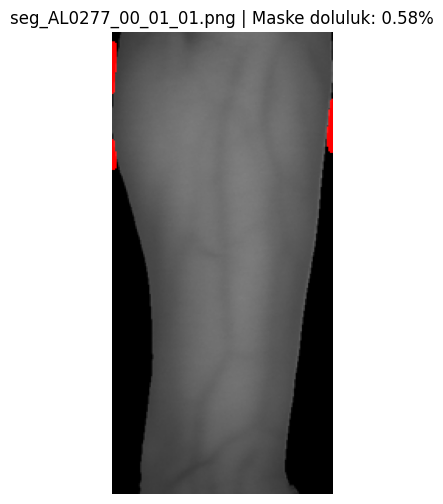

In [ ]:
# Tek örnek göster
show_overlay("seg_AL0277_00_01_01.png")


In [ ]:
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR_DIR    = ROOT/"IR/Imgseg_01"
MASK_DIR  = ROOT/"masks_IR/Imgseg_01"

def crop_to_arm(ir, msk, top=40, margin=8):
    # Üst şeridi kırp
    ir  = ir[top:, :]
    msk = msk[top:, :]

    # Kol bölgesini bul (Otsu + kapama)
    _, arm = cv2.threshold(ir, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    arm = cv2.morphologyEx(arm, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8), iterations=1)

    cnts = cv2.findContours(arm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        # Kenarlardan güvenlik payı
        x  = max(x + margin, 0)
        w  = max(w - 2*margin, 1)
        ir  = ir[y:y+h, x:x+w]
        msk = msk[y:y+h, x:x+w]

    # Ek güvenlik: maskede sağ/sol kenar şeritlerini sıfırla
    msk[:, :margin]  = 0
    msk[:, -margin:] = 0
    return ir, msk

def show_overlay(ir_name: str, top=40, margin=8, alpha=0.45):
    ir_p   = IR_DIR/ir_name
    mask_p = MASK_DIR/ir_name.replace(".png", "_mask.png")

    ir  = cv2.imread(str(ir_p),  cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(str(mask_p), cv2.IMREAD_GRAYSCALE)
    if ir is None or msk is None:
        print("Dosya bulunamadı:", ir_p, mask_p); return
    if ir.shape != msk.shape:
        msk = cv2.resize(msk, (ir.shape[1], ir.shape[0]), interpolation=cv2.INTER_NEAREST)

    # >>> otomatik kola kırp + kenar temizliği
    ir, msk = crop_to_arm(ir, msk, top=top, margin=margin)

    # Görselleştirme
    ir_f = ir.astype(np.float32)/255.0
    ir_rgb = np.dstack([ir_f, ir_f, ir_f])
    mask_bool = msk > 0
    overlay = ir_rgb.copy()
    overlay[mask_bool, 0] = 1.0
    overlay[mask_bool, 1] *= (1-alpha)
    overlay[mask_bool, 2] *= (1-alpha)

    fill = mask_bool.mean() * 100
    plt.figure(figsize=(7,6))
    plt.imshow(overlay); plt.axis("off")
    plt.title(f"{ir_p.name} | Maske doluluk: {fill:.2f}%")
    plt.show()


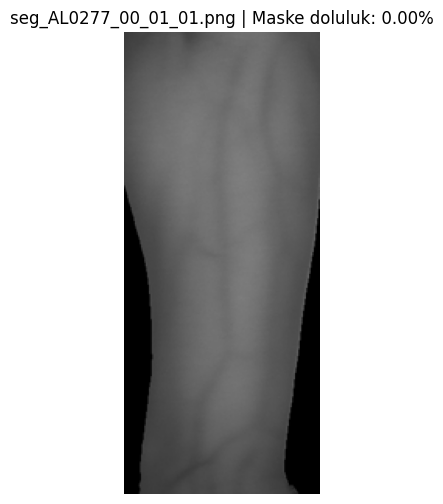

In [ ]:
show_overlay("seg_AL0277_00_01_01.png")


Maske unique: [  0 255]  | >0 piksel sayısı: 2298


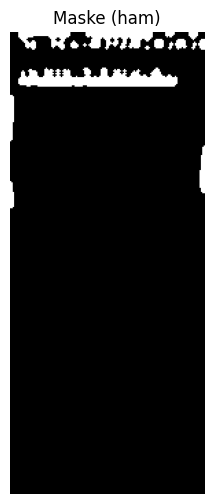

In [ ]:
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR   = ROOT/"IR/Imgseg_01/seg_AL0277_00_01_01.png"
MSK  = ROOT/"masks_IR/Imgseg_01/seg_AL0277_00_01_01_mask.png"

ir  = cv2.imread(str(IR), 0)
msk = cv2.imread(str(MSK), 0)

print("Maske unique:", np.unique(msk)[:10], " | >0 piksel sayısı:", int((msk>0).sum()))
plt.figure(figsize=(4,6)); plt.imshow(msk, cmap="gray"); plt.title("Maske (ham)"); plt.axis("off"); plt.show()


In [ ]:
from pathlib import Path
import cv2, numpy as np

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
SPLIT = "Imgseg_01"
IR_DIR   = ROOT/f"IR/{SPLIT}"
MSK_IN   = ROOT/f"masks_IR/{SPLIT}"
MSK_OUT  = ROOT/f"masks_IR_clean/{SPLIT}"
MSK_OUT.mkdir(parents=True, exist_ok=True)

def clean_mask_one(name, crop_top=60, margin=10, max_area_keep=5000):
    ir_p  = IR_DIR/name
    m_in  = MSK_IN/name.replace(".png", "_mask.png")
    m_out = MSK_OUT/name.replace(".png", "_mask.png")

    msk = cv2.imread(str(m_in), 0)
    if msk is None:
        print("Yok:", m_in); return

    # 1) Üst şerit ve kenarları sıfırla
    h,w = msk.shape
    msk[:crop_top, :] = 0
    msk[:, :margin]   = 0
    msk[:, -margin:]  = 0

    # 2) Çok büyük bileşenleri sil (başlık/arka plan yakalanmışsa)
    n, labels, stats, _ = cv2.connectedComponentsWithStats((msk>0).astype(np.uint8), connectivity=8)
    keep = np.zeros_like(msk)
    for i in range(1, n):  # 0 = arka plan
        area = stats[i, cv2.CC_STAT_AREA]
        if area <= max_area_keep:
            keep[labels==i] = 255
    msk = keep

    # 3) Küçük temizlik (isteğe bağlı)
    msk = cv2.morphologyEx(msk, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    msk = cv2.morphologyEx(msk, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8), iterations=1)

    cv2.imwrite(str(m_out), msk)
    print("Kaydedildi:", m_out)

# Tek örnek
clean_mask_one("seg_AL0277_00_01_01.png")


Kaydedildi: /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/masks_IR_clean/Imgseg_01/seg_AL0277_00_01_01_mask.png


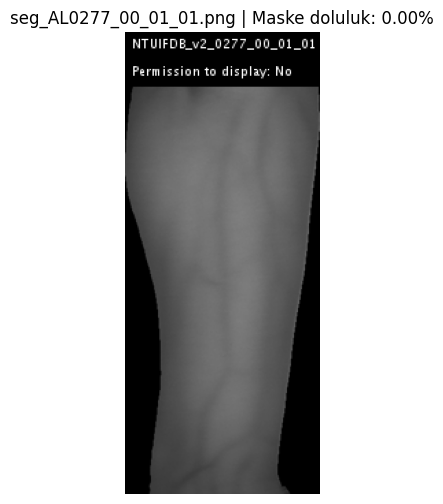

In [ ]:
import matplotlib.pyplot as plt

def show_overlay_clean(name):
    ir  = cv2.imread(str(IR_DIR/name), 0)
    msk = cv2.imread(str((ROOT/f"masks_IR_clean/{SPLIT}")/name.replace(".png","_mask.png")), 0)
    if ir is None or msk is None:
        print("Dosya yok"); return
    ir_f = (ir/255.0).astype(np.float32)
    rgb  = np.dstack([ir_f, ir_f, ir_f])
    mb   = msk>0
    overlay = rgb.copy()
    overlay[mb,0] = 1.0
    overlay[mb,1] *= 0.55
    overlay[mb,2] *= 0.55
    fill = mb.mean()*100
    plt.figure(figsize=(4,6))
    plt.imshow(overlay); plt.axis("off")
    plt.title(f"{name} | Maske doluluk: {fill:.2f}%")
    plt.show()

show_overlay_clean("seg_AL0277_00_01_01.png")


In [ ]:
from pathlib import Path
import cv2, numpy as np
p = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
name = "seg_AL0277_00_01_01.png"           # aynı örnek
m = cv2.imread(str(p/f"masks_IR/Imgseg_01/{name.replace('.png','_mask.png')}"), 0)
print("masks_IR >0:", int((m>0).sum()) if m is not None else "yok")

mc = cv2.imread(str(p/f"masks_IR_clean/Imgseg_01/{name.replace('.png','_mask.png')}"), 0)
print("masks_IR_clean >0:", int((mc>0).sum()) if mc is not None else "yok")


masks_IR >0: 2298
masks_IR_clean >0: 0


In [ ]:
from skimage.filters import frangi, sato
from skimage.morphology import disk
from skimage import morphology as morph

def make_mask_v3(ir, crop_top=60, margin=6,
                 clahe_clip=2.0, clahe_grid=8,
                 blur_ksize=5, frangi_beta=0.5, frangi_gamma=15,
                 p_hi=88, min_cc=25, max_cc=15000,
                 erode_border_px=25):
    # 0) kırp + yanal margin temizle
    ir = ir[crop_top:, :].copy()
    ir[:, :margin]  = 0
    ir[:, -margin:] = 0

    # 1) ROI: kaba kol maskesi (Otsu) ve içe erode -> dış kenarı bastır
    _g = cv2.GaussianBlur(ir, (5,5), 0)
    _, roi = cv2.threshold(_g, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    roi = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), iterations=1)
    if erode_border_px > 0:
        roi = cv2.erode(roi, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(erode_border_px,erode_border_px)), iterations=1)

    # 2) Kontrast artırma: CLAHE + median + black-hat
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(clahe_grid, clahe_grid))
    x = clahe.apply(ir)
    x = cv2.medianBlur(x, blur_ksize)
    bh = cv2.morphologyEx(x, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT,(17,17)))
    enh = cv2.addWeighted(x, 0.5, bh, 1.0, 0)

    # 3) Vesselness (sato genelde ince damar için iyi) + normalize
    v = sato(enh.astype(np.float32)/255.0, sigmas=range(1,4), black_ridges=True)
    v = (v - np.nanmin(v)) / (np.nanmax(v)-np.nanmin(v) + 1e-6)

    # 4) Yüzdelik eşik (sadece ROI içinde hesaplansın)
    vv = v[(roi>0)]
    thr = np.percentile(vv, p_hi) if vv.size else 1.0
    m = (v >= thr).astype(np.uint8)*255
    m[roi==0] = 0  # ROI dışını tamamen kapat

    # 5) Bağlı bileşen temizliği
    n,lab,stats,_ = cv2.connectedComponentsWithStats((m>0).astype(np.uint8), connectivity=8)
    keep = np.zeros_like(m)
    for i in range(1,n):
        area = stats[i, cv2.CC_STAT_AREA]
        if min_cc <= area <= max_cc:
            keep[lab==i] = 255

    # 6) İnce temizlik + istersen skeleton (yorum satırı)
    k = np.ones((3,3), np.uint8)
    keep = cv2.morphologyEx(keep, cv2.MORPH_OPEN, k, iterations=1)
    keep = cv2.morphologyEx(keep, cv2.MORPH_CLOSE, k, iterations=1)
    # keep = (morph.skeletonize((keep>0)).astype(np.uint8))*255

    return keep, v, roi, enh


>0 piksel: 2533


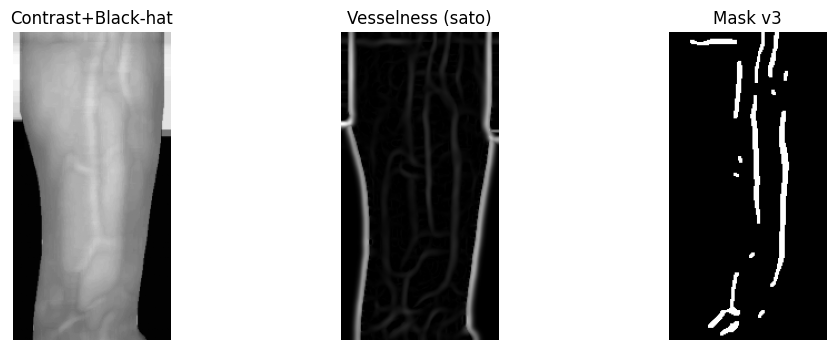

In [ ]:
name = "seg_AL0277_00_01_01.png"
ir = cv2.imread(str(IR_DIR/name), 0)
msk, vessel, roi, enh = make_mask_v3(ir)

print(">0 piksel:", int((msk>0).sum()))
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(enh, cmap="gray"); plt.title("Contrast+Black-hat"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(vessel, cmap="gray"); plt.title("Vesselness (sato)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(msk, cmap="gray"); plt.title("Mask v3"); plt.axis("off")
plt.show()


In [ ]:
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR_DIR = ROOT/"IR/Imgseg_01"
MASK_OUT = ROOT/"masks_IR_v3/Imgseg_01"

def show_overlay_v3(name):
    ir  = cv2.imread(str(IR_DIR/name), 0)
    msk = cv2.imread(str(MASK_OUT/name.replace(".png","_mask.png")), 0)
    if ir is None or msk is None:
        print("Bulunamadı:", name); return

    # üst şerit kırpması v3 ile aynı olmalı (crop_top=60)
    crop_top = 60
    ir  = ir[crop_top:, :]
    msk = msk[crop_top:, :]

    ir_f  = ir.astype(np.float32)/255.0
    rgb   = np.dstack([ir_f, ir_f, ir_f])
    maskb = msk > 0
    alpha = 0.45
    over  = rgb.copy()
    over[maskb,0] = 1.0
    over[maskb,1] *= (1-alpha)
    over[maskb,2] *= (1-alpha)

    fill = maskb.mean()*100
    plt.figure(figsize=(5,8)); plt.imshow(over); plt.axis("off")
    plt.title(f"{name} | Maske doluluk: {fill:.2f}%"); plt.show()

# Örnek:
show_overlay_v3("seg_AL0277_00_01_01.png")


Bulunamadı: seg_AL0277_00_01_01.png


In [ ]:
from pathlib import Path
import cv2

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR_P   = ROOT/"IR/Imgseg_01/seg_AL0277_00_01_01.png"
OUT_D  = ROOT/"masks_IR_v3/Imgseg_01"
OUT_D.mkdir(parents=True, exist_ok=True)

# 1) IR'yi oku ve maskeyi üret
ir = cv2.imread(str(IR_P), 0)
msk, *_ = make_mask_v3(ir)   # senin v3 fonksiyonun

# 2) Diske yaz
OUT_P = OUT_D/"seg_AL0277_00_01_01_mask.png"
cv2.imwrite(str(OUT_P), msk)

# 3) Sonra overlay fonksiyonunu çağır
show_overlay_v3("seg_AL0277_00_01_01.png")


IndexError: boolean index did not match indexed array along axis 0; size of axis is 278 but size of corresponding boolean axis is 218

IR shape: (338, 142) MSK shape: (338, 142)


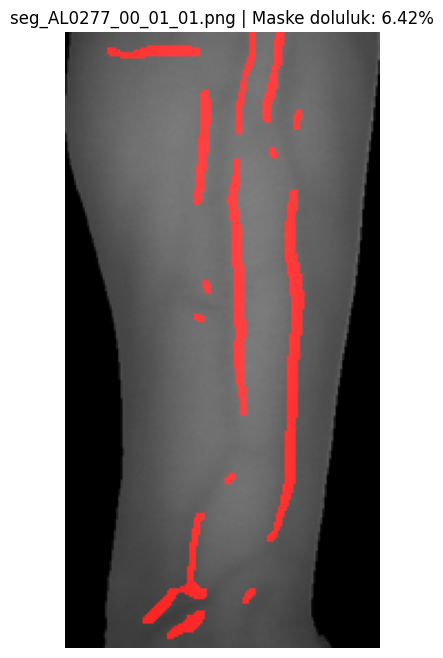

In [ ]:
# Maskeyi üret
ir = cv2.imread(str(IR_P), 0)
msk, *_ = make_mask_v3(ir)      # bu msk yüksekliği = ir_h - 60

# Tam boya padle (üst kısma 60 px siyah ekle)
crop_top = 60
pad = np.zeros((crop_top, ir.shape[1]), np.uint8)
msk_full = np.vstack([pad, msk])    # artık msk_full.shape == ir.shape

cv2.imwrite(str(OUT_P), msk_full)
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR_DIR   = ROOT/"IR/Imgseg_01"
MASK_DIR = ROOT/"masks_IR_v3/Imgseg_01"   # az önce kaydettiğin klasör

name = "seg_AL0277_00_01_01.png"         # örnek dosya

ir  = cv2.imread(str(IR_DIR/name), 0)
msk = cv2.imread(str(MASK_DIR/name.replace(".png","_mask.png")), 0)

print("IR shape:", ir.shape, "MSK shape:", msk.shape)

# İstersen görsel amaçlı üst şeridi kırp (sadece gösterimde)
crop_top = 60
ir_v  = ir[crop_top:, :]
msk_v = msk[crop_top:, :]

# Overlay
ir_f  = ir_v.astype(np.float32)/255.0
rgb   = np.dstack([ir_f, ir_f, ir_f])
maskb = msk_v > 0
alpha = 0.45
over  = rgb.copy()
over[maskb,0] = 1.0
over[maskb,1] *= (1-alpha)
over[maskb,2] *= (1-alpha)

fill = maskb.mean()*100
plt.figure(figsize=(5,8)); plt.imshow(over); plt.axis("off")
plt.title(f"{name} | Maske doluluk: {fill:.2f}%"); plt.show()



In [ ]:
from pathlib import Path
import cv2, numpy as np

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
for split in ["Imgseg_01", "Imgseg_02"]:
    IR_DIR   = ROOT/f"IR/{split}"
    MASK_DIR = ROOT/f"masks_IR_v3/{split}"
    MASK_DIR.mkdir(parents=True, exist_ok=True)

    imgs = sorted(IR_DIR.glob("*.png"))
    zero = 0
    for p in imgs:
        ir = cv2.imread(str(p), 0)
        msk, *_ = make_mask_v3(ir)         # senin v3 fonksiyonun
        crop_top = 60
        pad = np.zeros((crop_top, ir.shape[1]), np.uint8)
        msk_full = np.vstack([pad, msk])
        cv2.imwrite(str(MASK_DIR/f"{p.stem}_mask.png"), msk_full)
        zero += int((msk_full>0).sum()==0)
    print(f"[{split}] toplam {len(imgs)} | boş maske: {zero}")


[Imgseg_01] toplam 656 | boş maske: 0
[Imgseg_02] toplam 656 | boş maske: 0


In [ ]:
from pathlib import Path
import cv2, numpy as np
import pandas as pd

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
rows = []
for split in ["Imgseg_01","Imgseg_02"]:
    ir_dir  = ROOT/f"IR/{split}"
    msk_dir = ROOT/f"masks_IR_v3/{split}"
    for p in sorted(ir_dir.glob("*.png")):
        ir  = cv2.imread(str(p), 0)
        msk = cv2.imread(str(msk_dir/f"{p.stem}_mask.png"), 0)
        h,w = ir.shape
        fill = (msk>0).mean()*100.0
        rows.append({"split":split,"name":p.name,"h":h,"w":w,"fill_pct":fill})

df = pd.DataFrame(rows)
print(df.describe(percentiles=[.01,.05,.5,.95,.99]).round(3))
low  = df[df.fill_pct < 0.2]
high = df[df.fill_pct > 12.0]
print("\nŞüpheli (az doluluk):", len(low))
print("Şüpheli (çok doluluk):", len(high))
low.to_csv("/content/mask_suspect_low.csv", index=False)
high.to_csv("/content/mask_suspect_high.csv", index=False)
print("CSV'ler kaydedildi:", "/content/mask_suspect_low.csv", "/content/mask_suspect_high.csv")


            h       w  fill_pct
count  1312.0  1312.0  1312.000
mean    338.0   142.0     4.215
std       0.0     0.0     1.599
min     338.0   142.0     0.669
1%      338.0   142.0     1.026
5%      338.0   142.0     1.292
50%     338.0   142.0     5.006
95%     338.0   142.0     5.738
99%     338.0   142.0     6.056
max     338.0   142.0     6.632

Şüpheli (az doluluk): 0
Şüpheli (çok doluluk): 0
CSV'ler kaydedildi: /content/mask_suspect_low.csv /content/mask_suspect_high.csv


In [ ]:
from pathlib import Path
import random

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
splits_dir = ROOT/"splits"; splits_dir.mkdir(exist_ok=True)

imgs = sorted(list((ROOT/"IR/Imgseg_01").glob("*.png")) + list((ROOT/"IR/Imgseg_02").glob("*.png")))
random.seed(42); random.shuffle(imgs)
n = len(imgs); n_tr, n_va = int(0.8*n), int(0.1*n)

def dump(lst, name):
    with open(splits_dir/name, "w") as f:
        for p in lst: f.write(p.name+"\n")

dump(imgs[:n_tr], "train.txt")
dump(imgs[n_tr:n_tr+n_va], "val.txt")
dump(imgs[n_tr+n_va:], "test.txt")
print("train/val/test:", n_tr, n_va, n - n_tr - n_va)


train/val/test: 1049 131 132


In [ ]:
!pip -q install albumentations>=1.4.0


In [ ]:
import cv2, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import albumentations as A

ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")

class VeinDataset(Dataset):
    def __init__(self, root, list_txt):
        self.root = Path(root)
        with open(self.root/"splits"/list_txt) as f:
            self.names = [l.strip() for l in f if l.strip()]

        # Aynı isim iki splitte de olabilir → hangisi varsa onu eşle
        self.pairs = []
        for n in self.names:
            hit = None
            for split in ["Imgseg_01","Imgseg_02"]:
                ip = self.root/f"IR/{split}/{n}"
                mp = self.root/f"masks_IR_v3/{split}/{n.replace('.png','_mask.png')}"
                if ip.exists() and mp.exists():
                    hit = (ip, mp); break
            if hit: self.pairs.append(hit)

        # Basit dönüşümler (hızlı deneme için)
        self.tf = A.Compose([
            A.Resize(320, 128, interpolation=cv2.INTER_LINEAR),
            A.HorizontalFlip(p=0.5),
        ])

    def __len__(self): return len(self.pairs)

    def __getitem__(self, i):
        ip, mp = self.pairs[i]
        ir  = cv2.imread(str(ip), 0)
        msk = cv2.imread(str(mp), 0)
        aug = self.tf(image=ir, mask=msk)
        ir, msk = aug["image"], aug["mask"]
        ir  = (ir.astype(np.float32)/255.0)[None, ...]       # (1,H,W)
        msk = (msk>0).astype(np.float32)[None, ...]          # (1,H,W)
        return torch.from_numpy(ir), torch.from_numpy(msk), ip.name


In [ ]:
from torch.utils.data import DataLoader

ds_tr = VeinDataset(ROOT, "train.txt")
dl_tr = DataLoader(ds_tr, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

x, y, names = next(iter(dl_tr))
print("Batch shapes:", x.shape, y.shape)  # beklenen: [B,1,320,128]
print("Örnek dosyalar:", list(names)[:3])
print("IR min/max:", float(x.min()), float(x.max()), "| Mask uniq:", y.unique())


Batch shapes: torch.Size([8, 1, 320, 128]) torch.Size([8, 1, 320, 128])
Örnek dosyalar: ['seg_AR0170_00_01_01.png', 'seg_AR0253_00_02_01.png', 'seg_AR0219_00_02_01.png']
IR min/max: 0.0 0.9921568632125854 | Mask uniq: tensor([0., 1.])


In [ ]:
from pathlib import Path
import cv2, numpy as np, matplotlib.pyplot as plt
from datetime import datetime

# Proje kökü
ROOT = Path("/content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2")
IR_DIRS   = [ROOT/"IR/Imgseg_01", ROOT/"IR/Imgseg_02"]       # IR kaynakları
MASK_ROOT = ROOT/"masks_IR_v3"                               # Ürettiğin maskelerin kökü

# Çıkış: overlay ve gridler
OUT = ROOT/"debug_overlays"
(OUT/"train").mkdir(parents=True, exist_ok=True)
(OUT/"val").mkdir(parents=True, exist_ok=True)
(OUT/"test").mkdir(parents=True, exist_ok=True)

# Ne kadar dosya kaydedelim?
MAX_SAVE_PER_SPLIT = 10     # train/val/test başına
ALPHA = 0.45                # kırmızı bindirme şeffaflığı


In [ ]:
def build_paths_by_name(name: str):
    """
    train/val/test listelerinde yalnızca dosya adı (seg_....png) var.
    Bu ada göre gerçek IR ve mask yolunu bul.
    """
    # IR dosyası iki klasörden birinde olur
    for d in IR_DIRS:
        p = d/name
        if p.exists():
            ir_p = p
            break
    else:
        return None, None

    # Maskeyi v3 klasör yapısına göre bul (aynı split altında)
    split = ir_p.parent.name  # Imgseg_01 veya Imgseg_02
    mask_p = MASK_ROOT/split/f"{ir_p.stem}_mask.png"
    return ir_p, mask_p


def make_overlay(ir_img: np.ndarray, mask_img: np.ndarray, alpha=ALPHA):
    """
    Gri IR + ikili maskeyi (0/255) kırmızı bindirme ile birleştirip RGB döndür.
    (Maske v3 ile tam boy olduğu için ek kırpma gerekmiyor.)
    """
    ir_f  = ir_img.astype(np.float32)/255.0
    rgb   = np.dstack([ir_f, ir_f, ir_f])
    m     = mask_img > 0
    out   = rgb.copy()
    out[m, 0] = 1.0
    out[m, 1] *= (1-alpha)
    out[m, 2] *= (1-alpha)
    return (np.clip(out*255, 0, 255)).astype(np.uint8)


def save_overlay_by_name(name: str, out_path: Path):
    ir_p, mask_p = build_paths_by_name(name)
    if ir_p is None or not mask_p.exists():
        print("⛔ Bulunamadı:", name); return False

    ir  = cv2.imread(str(ir_p), 0)
    msk = cv2.imread(str(mask_p), 0)
    over = make_overlay(ir, msk)

    # cv2 BGR bekler; biz RGB ürettik, çevirip yazalım
    cv2.imwrite(str(out_path), cv2.cvtColor(over, cv2.COLOR_RGB2BGR))
    return True


In [ ]:
def read_list(fname: Path):
    with open(fname, "r") as f:
        return [ln.strip() for ln in f if ln.strip()]

splits_dir = ROOT/"splits"
train_list = read_list(splits_dir/"train.txt")
val_list   = read_list(splits_dir/"val.txt")
test_list  = read_list(splits_dir/"test.txt")

print(f"train/val/test: {len(train_list)} {len(val_list)} {len(test_list)}")

def save_some(split_names, split_label: str, max_n=MAX_SAVE_PER_SPLIT):
    saved = 0
    for name in split_names:
        if saved >= max_n: break
        ok = save_overlay_by_name(name, (OUT/split_label)/f"{name.replace('.png','')}_overlay.png")
        if ok: saved += 1
    print(f"✅ {split_label}: {saved} overlay kaydedildi -> {OUT/split_label}")

save_some(train_list, "train")
save_some(val_list,   "val")
save_some(test_list,  "test")


train/val/test: 1049 131 132
✅ train: 10 overlay kaydedildi -> /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/debug_overlays/train
✅ val: 10 overlay kaydedildi -> /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/debug_overlays/val
✅ test: 10 overlay kaydedildi -> /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/debug_overlays/test


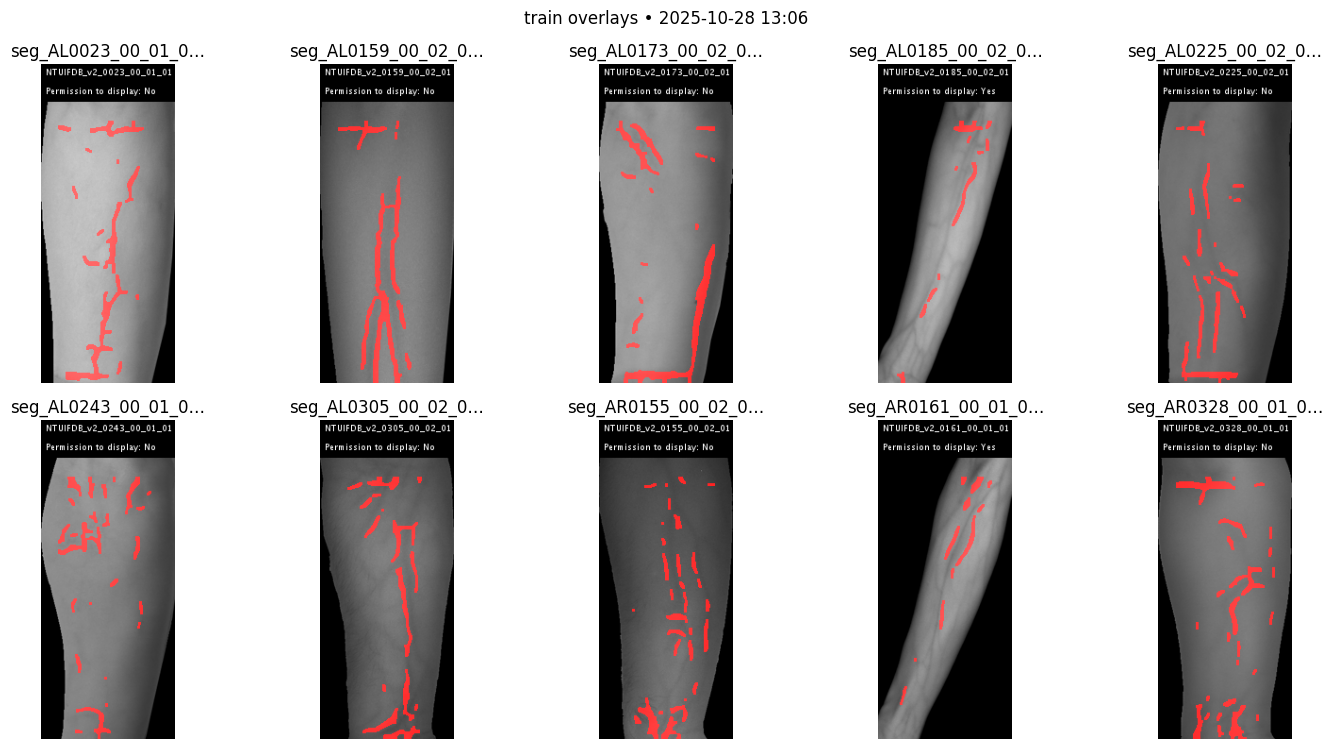

🖼️ Grid kaydedildi: /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/debug_overlays/grid_train.png


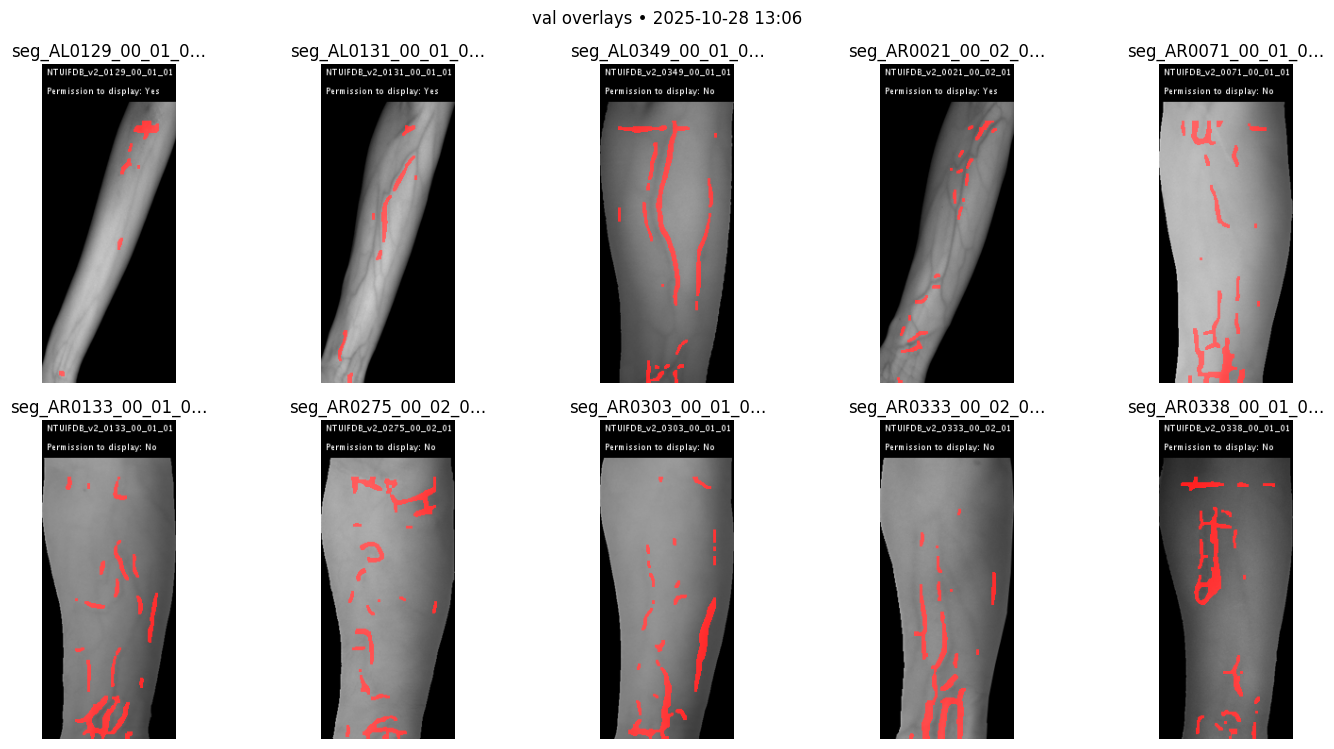

🖼️ Grid kaydedildi: /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/debug_overlays/grid_val.png


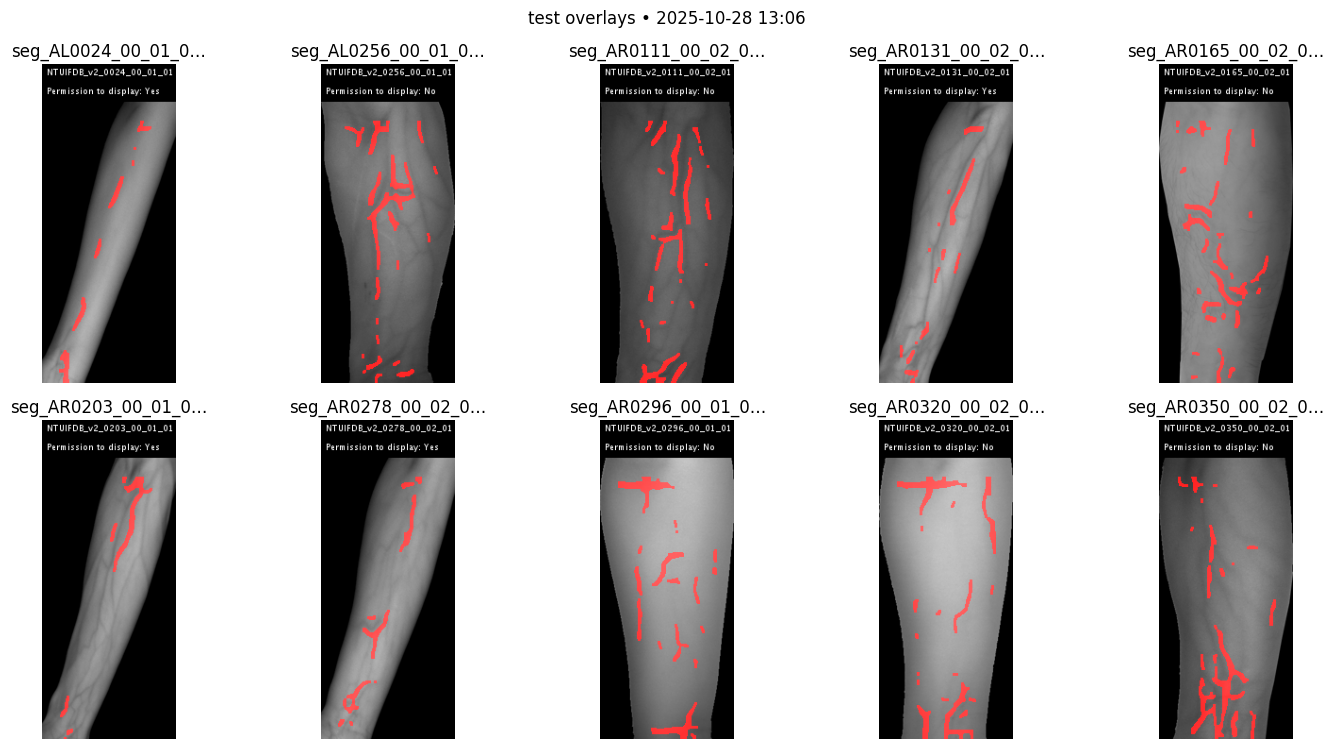

🖼️ Grid kaydedildi: /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/debug_overlays/grid_test.png


In [ ]:
def save_grid(split_label: str, cols=5):
    folder = OUT/split_label
    imgs = sorted(folder.glob("*_overlay.png"))
    if not imgs:
        print("⛔ Grid için yeterli görsel yok:", folder); return
    cols = min(cols, len(imgs))
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=(3*cols, 3.8*rows))
    for i,p in enumerate(imgs, 1):
        im = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i); plt.imshow(im); plt.axis("off"); plt.title(p.name[:18]+"…")
    plt.suptitle(f"{split_label} overlays • {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    out_png = OUT/f"grid_{split_label}.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=180)
    plt.show()
    print("🖼️ Grid kaydedildi:", out_png)

save_grid("train")
save_grid("val")
save_grid("test")


In [ ]:
readme = OUT/"README.txt"
readme.write_text(f"""Debug overlays
================

Tarih: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Kaynak: {ROOT}
IR klasörleri: {', '.join(str(d) for d in IR_DIRS)}
Maskeler: {MASK_ROOT}
Parametreler: crop_top=60 (v3 pipeline içinde), overlay_alpha={ALPHA}, resize yok (320x128 dataset yükleyicide uygulanıyor olabilir)
Her split için en çok {MAX_SAVE_PER_SPLIT} örnek kaydedildi.

Dosyalar:
- train/, val/, test/ altında *_overlay.png
- grid_train.png, grid_val.png, grid_test.png

Not: Bu görseller raporda yöntem bölümünde “örnek maske bindirme” olarak kullanılabilir.
""")
print("📝 README yazıldı:", readme)


📝 README yazıldı: /content/avist-vene-detection-ml/data/NTU_Inner_Forearm_v2/debug_overlays/README.txt


In [9]:
# Repo daha önce klonlandı mı? Hızlı teşhis
import os, subprocess

HOST     = "gitlab.lrz.de"  # gitlab.com kullanıyorsan değiştir
REPO     = "avist/avist-vene-detection-ml"
REPO_DIR = "/content/avist-vene-detection-ml"

print("CWD:", os.getcwd())
print("REPO_DIR var mı? ->", os.path.isdir(REPO_DIR))

def is_git_repo(path):
    try:
        return subprocess.run(
            ["git","-C", path, "rev-parse","--is-inside-work-tree"],
            capture_output=True, text=True
        ).returncode == 0
    except Exception:
        return False

if os.path.isdir(REPO_DIR) and is_git_repo(REPO_DIR):
    print("✅ Bu dizin bir Git reposu: KLONLANMIŞ.")
    # İstersen durumuna bak:
    # %cd /content/avist-vene-detection-ml
    # !git remote -v
    # !git status
elif os.path.isdir(REPO_DIR):
    print("⚠️ Klasör var ama Git repo değil (veya bozuk). Silip tekrar klonlamak mantıklı.")
else:
    print("❌ Klon YOK. [B] hücresindeki klon adımını çalıştırmalısın.")


CWD: /content/avist-vene-detection-ml
REPO_DIR var mı? -> True
✅ Bu dizin bir Git reposu: KLONLANMIŞ.
